Comencemos por considerar el problema de limpieza de imágenes por Variación Total con la notación usada por el algoritmo Compuesto. Recordemos que
$$\Omega = \{1, \dots, n\}^2, \quad \Omega' = \{1, \dots, n-1\}^2$$
Y entonces se tiene que
$$E = \mathbb{R}^{\Omega}, \quad \langle x, y \rangle_E = \operatorname{Tr}\left(x^Ty\right) = \sum_{(i, j) \in \Omega}x_{i, j}y_{i, j}$$
Además, tenemos parámetros fijos $a \in E$, $\lambda > 0$. Así, podemos notar que $f$ corresponde a
$$f(x) = \Psi(x) = \frac{1}{2}\sum_{(i, j) \in \Omega}\left(x_{i, j} - a_{i, j}\right)^2$$
Y además, $g$ es 
$$g(x) = \lambda \Phi(\operatorname{Grad} x) = \lambda \sum_{(i, j) \in \Omega'} \sqrt{(x_{i+1, j} - x_{i, j})^2  + (x_{i, j+1} - x_{i, j})^2}$$
Es claro que se cumplen los primeros dos supuestos, puesto que $f$ y $g$ son bien regulares. Ahora veamos el tercer supuesto, se tiene que
$$(P_{\eta, z}) = \min_{x\in E}\left\{\sum_{(i, j) \in \Omega}z_{i, j}x_{i, j} + \frac{1}{\eta}\sum_{(i, j) \in \Omega}x_{i, j}^2 + \lambda \sum_{(i, j) \in \Omega'} \sqrt{(x_{i+1, j} - x_{i, j})^2  + (x_{i, j+1} - x_{i, j})^2}\right\}$$
Y al parecer se puede resolver este poblema eficientemente con muy alta precisión con la librería provista. No me voy a enfocar mucho en este problema ya que el que verdaderamente nos interesa es $T_\eta(y)$. Tenemos que
$$T_\eta(y) = \argmin_{x\in E}\left\{f(y) + \langle \nabla y, x - y \rangle + \frac{1}{2\eta}\|x-y\|^2 + g(x)\right\}$$
Eliminamos el término $f(y)$ puesto que no depende de $x$. Además, expandimos el segundo y tercer término
$$T_\eta(y) = \argmin_{x\in E}\left\{\langle \nabla y, x \rangle - \langle \nabla y, y \rangle + \frac{1}{2\eta}\left(\langle x, x \rangle - 2\langle y, x \rangle + \langle y, y \rangle\right) + g(x)\right\}$$
Sacamos lo que depende solamente de $y$, y dejemos todo el término que depende de $x$ metido en el paréntesis y escribamos $\langle x, x \rangle = \|x\|^2$. Entonces
$$T_\eta(y) = \argmin_{x\in E}\left\{\frac{1}{2\eta}\left(\|x\|^2- 2\langle y - \eta \nabla y, x \rangle\right) + g(x)\right\}$$
Agregamos el término $\frac{1}{2\eta}\|y - \eta \nabla y \|^2$, ya que no depende de $x$, y entonces
$$T_\eta(y) = \argmin_{x\in E}\left\{\frac{1}{2\eta}\left(\|x\|^2- 2\langle y - \eta \nabla y, x \rangle + \|y - \eta \nabla y \|^2\right) + g(x)\right\}$$
Y completamos el cuadrado
$$T_\eta(y) = \argmin_{x\in E}\left\{\frac{1}{2\eta}\|x - (y - \eta\nabla y)\|^2 + g(x)\right\}$$
Multiplicando por $\eta > 0$, y reemplazando por $g$ resulta que
$$T_\eta(y) = \argmin_{x\in E}\left\{\frac{1}{2}\|x - (y - \eta\nabla y)\|^2 + \eta\lambda \sum_{(i, j) \in \Omega'} \sqrt{(x_{i+1, j} - x_{i, j})^2  + (x_{i, j+1} - x_{i, j})^2}\right\}$$
Y con esto tenemos el problema de operador proximal para la variación total isotrópica con $z = y - \eta\nabla y$ y constante $\eta\lambda$, y por tanto podemos utilizar la librería provista para poder resolver el problema.

Comencemos por importar las librerías necesarias

In [358]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from prox_tv import tv1_2d

Implementemos las funciones correspondientes al problema

In [359]:
def f(x, c):
    return 0.5*np.sum((x - c)**2)

def fgrad(x, c):
    return x - c

def T(y, eta, c, Lambda):
    grady = fgrad(y, c)
    z = y - eta*grady
    x_opt = tv1_2d(z, eta*Lambda)
    return x_opt

def g(x, Lambda):
    dx = np.abs(x[1:, :] - x[:-1, :])
    dy = np.abs(x[:, 1:] - x[:, :-1])
    tv = np.sum(dx) + np.sum(dy)
    return Lambda*tv

def F(x, c, Lambda):
    return f(x, c) + g(x, Lambda)

def inner(x, y):
    return np.sum(x*y)

def sqnorm(x):
    return inner(x, x)

def norm(x):
    return np.sqrt(sqnorm(x))


E implementemos con las funciones que nos permitan leer y trabajar con imágenes y matrices

In [360]:
def leer(ruta):
    img = Image.open(ruta)
    array = np.array(img)

    if img.mode == 'I;16':
        array = (array / 256).astype(np.uint8)
        img = Image.fromarray(array, mode='L')

    return img.convert('L')

def tomatrix(imagen):
    return np.asarray(imagen).astype(np.float64)

def show(fotos, titulos = ["Original", "Ruidosa", "Reconstruida"]):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(fotos[i], cmap = 'gray')
        plt.title(titulos[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def tophoto(matriz):
    matriz_uint8 = np.clip(matriz, 0, 255).astype(np.uint8)
    return Image.fromarray(matriz_uint8)


Implementemos el Algoritmo 1. Le voy a poner un máximo de iteraciones de 100 nomás porque en verdad converge super rapido pero se me demora

In [361]:
def Compuesto(x0, c, xstar, Lambda, iters = 100):
    x = x0.copy()
    eta = 1
    error = [norm(x - xstar)]
    for t in range(iters):
        while True:
            y = T(x, eta, c, Lambda)
            if f(y, c) <= f(x, c) + inner(fgrad(x, c), y - x) + (1/(2*eta))*sqnorm(y - x):
                x = y
                break
            else:
                eta = (1/2)*eta
        error.append(norm(x - xstar))
    return x, error

Hagamos una función para encontrar un Lambda bueno. Lo que hago es comenzar desde la imagen original, hago unas 10 iteraciones y veo para que Lambda se me aleja menos de la imagen original.

In [362]:
def error(Lambda, moriginal, mruidosa):
    mreconstruida, _ = Compuesto(moriginal, mruidosa, moriginal, Lambda, iters = 10)
    return norm(mreconstruida - moriginal)

def findLambda(moriginal, mruidosa):
    Lambdas = [2**i for i in range(0, 7)]
    mini = error(0, moriginal, mruidosa)
    best = 0
    for Lambda in Lambdas:
        e = error(Lambda, moriginal, mruidosa)
        if e < mini:
            mini = e
            best = Lambda
    return best
    

Comencemos con los experimentos

El Lambda encontrado fue de: 16
El error fue de: 794.758765409935
Función Objetivo: 1951900.336346035


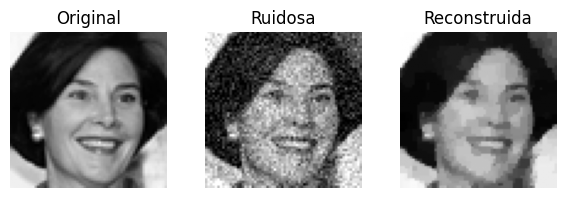

In [363]:
original = leer('laura.png')
ruidosa = leer('noisylaura.png')
moriginal = tomatrix(original)
mruidosa = tomatrix(ruidosa)
Lambda = findLambda(moriginal, mruidosa)
print("El Lambda encontrado fue de:", Lambda)
mreconstruida, elaura1 = Compuesto(np.zeros_like(mruidosa), mruidosa, moriginal, Lambda)
reconstruida = tophoto(mreconstruida)
print("El error fue de:", norm(mreconstruida - moriginal))
print("Función Objetivo:", F(mreconstruida, mruidosa, Lambda))
show([original, ruidosa, reconstruida])

El Lambda encontrado fue de: 8
El error fue de: 973.1508374088422
Función Objetivo: 3046246.2977887513


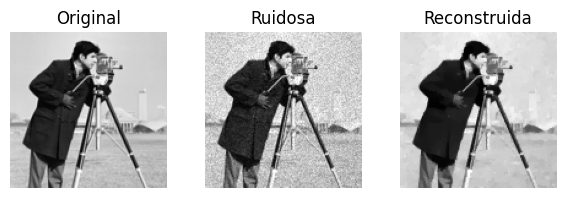

In [364]:
original = leer('camera.png')
ruidosa = leer('noisycamera.png')
moriginal = tomatrix(original)
mruidosa = tomatrix(ruidosa)
Lambda = findLambda(moriginal, mruidosa)
print("El Lambda encontrado fue de:", Lambda)
mreconstruida, ecamera1 = Compuesto(np.zeros_like(mruidosa), mruidosa, moriginal, Lambda)
reconstruida = tophoto(mreconstruida)
print("El error fue de:", norm(mreconstruida - moriginal))
print("Función Objetivo:", F(mreconstruida, mruidosa, Lambda))
show([original, ruidosa, reconstruida])

El Lambda encontrado fue de: 32
El error fue de: 3809.089576851272
Función Objetivo: 42465710.876164004


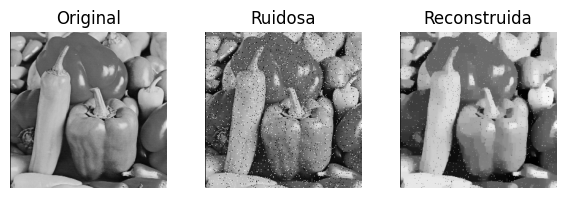

In [365]:
original = leer('peppers.png')
ruidosa = leer('noisypeppers.png')
moriginal = tomatrix(original)
mruidosa = tomatrix(ruidosa)
Lambda = findLambda(moriginal, mruidosa)
print("El Lambda encontrado fue de:", Lambda)
mreconstruida, epeppers1 = Compuesto(np.zeros_like(mruidosa), mruidosa, moriginal, Lambda)
reconstruida = tophoto(mreconstruida)
print("El error fue de:", norm(mreconstruida - moriginal))
print("Función Objetivo:", F(mreconstruida, mruidosa, Lambda))
show([original, ruidosa, reconstruida])

El Lambda encontrado fue de: 16
El error fue de: 21870.910259617765
Función Objetivo: 97464471.28286263


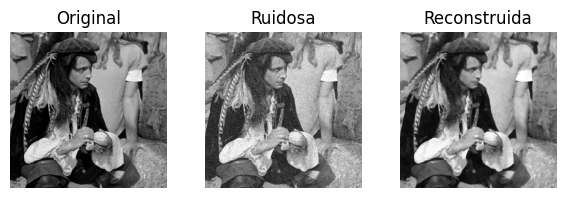

In [366]:
original = leer('pirate.png')
ruidosa = leer('noisypirate.png')
moriginal = tomatrix(original)
mruidosa = tomatrix(ruidosa)
Lambda = findLambda(moriginal, mruidosa)
print("El Lambda encontrado fue de:", Lambda)
mreconstruida, epirate1 = Compuesto(np.zeros_like(mruidosa), mruidosa, moriginal, Lambda)
reconstruida = tophoto(mreconstruida)
print("El error fue de:", norm(mreconstruida - moriginal))
print("Función Objetivo:", F(mreconstruida, mruidosa, Lambda))
show([original, ruidosa, reconstruida])

Notamos que el algoritmo pareciera estar funcionando correctamente. Es interesante notar que de hecho si tiene sentido el resultado, puesto que se puede notar como le quita el ruido a las imagenes. Lo otro que es importante a notar es que "suaviza" las imagenes, lo que le hace perder calidad, pero al final esa es su estrategia para poder disminuir el ruido. Como las suaviza, en las imágenes que mejor funciona es en las de mayor calidad, y esto se nota en los experimentos ya que las imágenes más grandes pareciera tener un mejor resultado.

Ahora implementemos una función para graficar los errores de los algoritmos en función de la iteración.

In [367]:
def errores(e1, e2):
    x = np.arange(101)

    plt.figure(figsize=(10, 5))
    plt.plot(x, e1, label='Compuesto', color='blue')
    plt.plot(x, e2, label='Compuesto Acelerado', color='orange')
    plt.xlabel('Iteración')
    plt.ylabel('Error')
    plt.title('Comparación entre métodos')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

E implementemos el algoritmo acelerado.

In [373]:
def AccCompuesto(x0, c, xstar, Lambda, iters = 100):
    x = x0.copy()
    y = x0.copy()
    z = x0.copy()    
    eta = 1
    A = 0
    error = [norm(y - xstar)]
    for t in range(iters):
        while True:
            alpha = 0.5*(eta + np.sqrt(eta**2 + 4*eta*A))
            At = A + alpha
            tau = alpha/At
            xt = tau*z + (1 - tau)*y
            yt = T(xt, 1, c, Lambda)
            if f(yt, c) <= f(xt, c) + inner(fgrad(xt, c), yt - xt) + (1/(2*eta))*sqnorm(yt - xt):
                x = xt
                y = yt
                A = At
                z = z - alpha*fgrad(x, c)
                break
            else:
                eta = (1/2)*eta
        error.append(norm(y - xstar))
    return y, error

Y hagamos los experimentos. Para cada imágen obviamente escojeremos el mismo lambda que antes.

El error fue de: 794.758765409935
Función Objetivo: 1951900.336346035


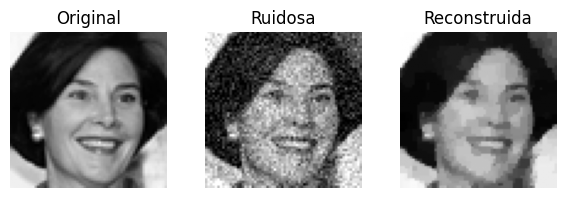

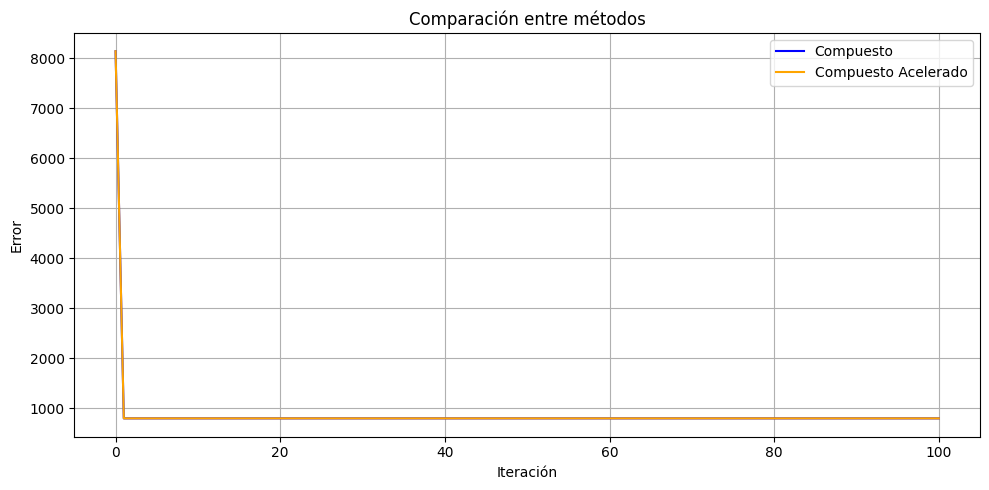

In [374]:
original = leer('laura.png')
ruidosa = leer('noisylaura.png')
moriginal = tomatrix(original)
mruidosa = tomatrix(ruidosa)
Lambda = findLambda(moriginal, mruidosa)
mreconstruida, elaura2 = AccCompuesto(np.zeros_like(mruidosa), mruidosa, moriginal, Lambda)
reconstruida = tophoto(mreconstruida)
print("El error fue de:", norm(mreconstruida - moriginal))
print("Función Objetivo:", F(mreconstruida, mruidosa, Lambda))
show([original, ruidosa, reconstruida])
errores(elaura1, elaura2)

El Lambda encontrado fue de: 8
El error fue de: 973.1508374088422
Función Objetivo: 3046246.2977887513


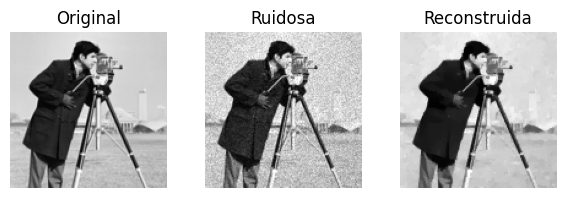

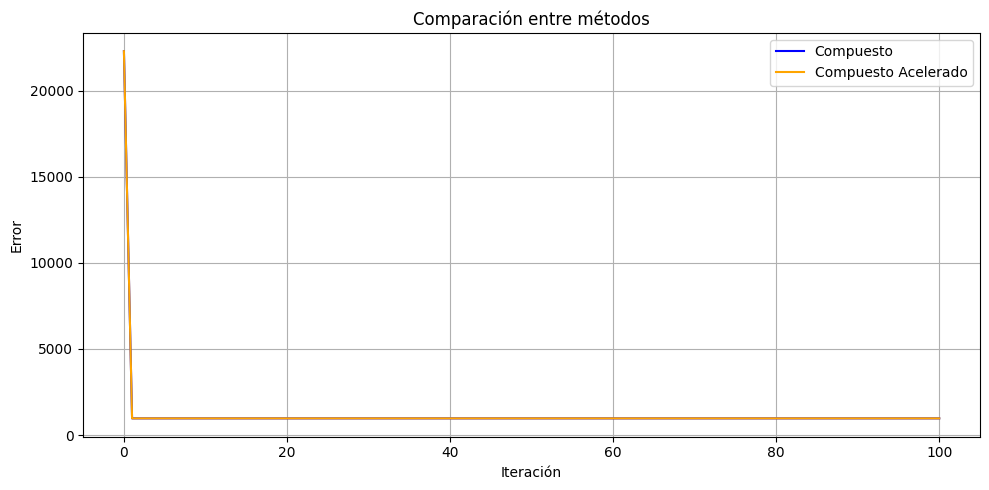

In [375]:
original = leer('camera.png')
ruidosa = leer('noisycamera.png')
moriginal = tomatrix(original)
mruidosa = tomatrix(ruidosa)
Lambda = findLambda(moriginal, mruidosa)
print("El Lambda encontrado fue de:", Lambda)
mreconstruida, ecamera2 = AccCompuesto(np.zeros_like(mruidosa), mruidosa, moriginal, Lambda)
reconstruida = tophoto(mreconstruida)
print("El error fue de:", norm(mreconstruida - moriginal))
print("Función Objetivo:", F(mreconstruida, mruidosa, Lambda))
show([original, ruidosa, reconstruida])
errores(ecamera1, ecamera2)

El Lambda encontrado fue de: 32
El error fue de: 3809.1283344916724
Función Objetivo: 42467050.04378125


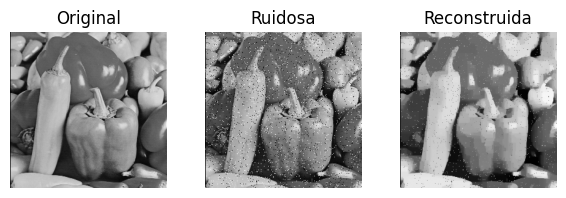

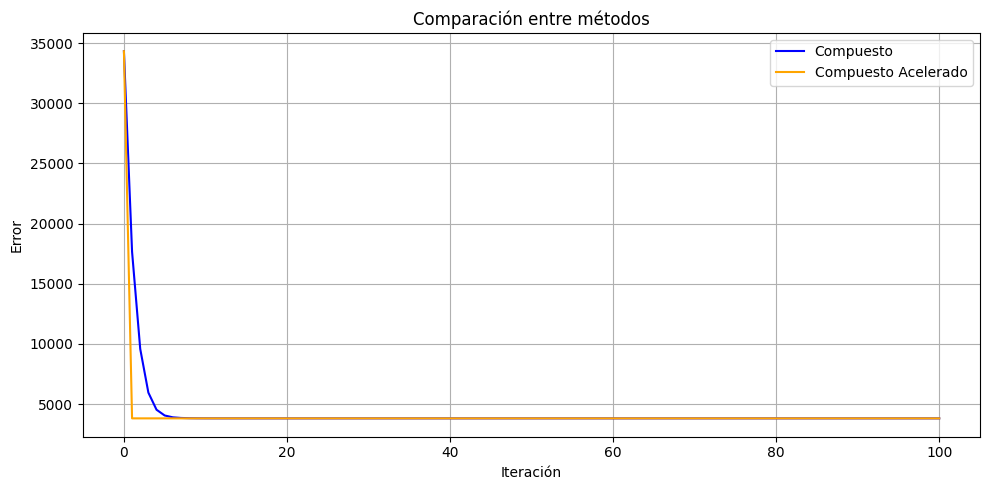

In [376]:
original = leer('peppers.png')
ruidosa = leer('noisypeppers.png')
moriginal = tomatrix(original)
mruidosa = tomatrix(ruidosa)
Lambda = findLambda(moriginal, mruidosa)
print("El Lambda encontrado fue de:", Lambda)
mreconstruida, epeppers2 = AccCompuesto(np.zeros_like(mruidosa), mruidosa, moriginal, Lambda)
reconstruida = tophoto(mreconstruida)
print("El error fue de:", norm(mreconstruida - moriginal))
print("Función Objetivo:", F(mreconstruida, mruidosa, Lambda))
show([original, ruidosa, reconstruida])
errores(epeppers1, epeppers2)

El Lambda encontrado fue de: 16
El error fue de: 21870.910259617765
Función Objetivo: 97464471.28286263


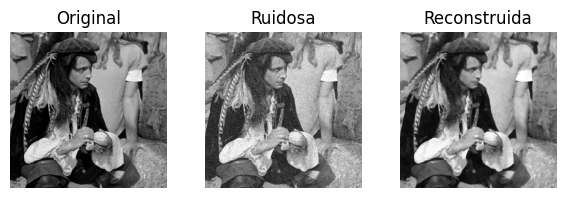

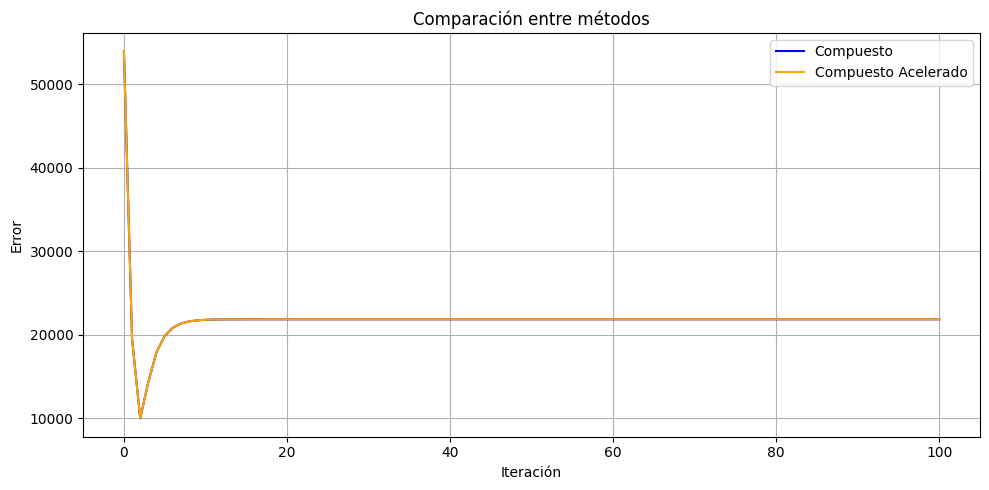

In [377]:
original = leer('pirate.png')
ruidosa = leer('noisypirate.png')
moriginal = tomatrix(original)
mruidosa = tomatrix(ruidosa)
Lambda = findLambda(moriginal, mruidosa)
print("El Lambda encontrado fue de:", Lambda)
mreconstruida, epirate2 = Compuesto(np.zeros_like(mruidosa), mruidosa, moriginal, Lambda)
reconstruida = tophoto(mreconstruida)
print("El error fue de:", norm(mreconstruida - moriginal))
print("Función Objetivo:", F(mreconstruida, mruidosa, Lambda))
show([original, ruidosa, reconstruida])
errores(epirate1, epirate2)

Podemos verificar que el algoritmo ha sido implementado correctamente, puesto que convergen al mismo error que el método anterior.

Notemos que en la tercera imagen, el algoritmo acelerado le saca ventaja considerable al anterior. En la cuarta imagen el error pareciera crecer, pero esto se debe a que nos piden graficar el error con respecto a la imagen original, y esa no es la función objetivo a optimizar, por lo que realmente la función objetivo a optimizar si decrece, solo que en el algoritmo no se conoce la imagen original. En todo caso, los algoritmos parecieran nuevamente empatar en esta imagen. En conclusión, como se demoran un tiempo similar y el acelerado le sacó ventaja en una, el acelerado es mejor.

En general, ambos métodos convergen demasiado rápido, así que considero que los algoritmos cumplen de muy buena manera su función. Aunque quizás la estrategia con imágenes de tan baja calidad no de resultados tan buenos, estoy seguro que con imágenes de más calidad los resultados deben ser excelentes. Igual, esto se debe puesto que la librería facilitada hace magia.